In [4]:
# Vol Surface Constructor

# 1/ Collect Data from YF
# 2/ Process and clean data
# 3/ Calculate IV
# 4/ Contsruct Vol Surface

In [5]:
# Updates

# Make the code more pythonic (use functions and call them rather than jsut blocks of code)
      # ---> made progress with this (almsot done)

# maybe add logic where we can mnaually remove outliers


# still dont fully understand RBF

# incorporate PDE into this "" (algebraic continuation YT video on quant roadmap 2025)

# I should be able to enter in a moneyness and matuirty and return an estimated vol or a new option

# notes for ##, do a summary at the top of each section, rather than each line, code should just be readable

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.interpolate import Rbf
from sklearn.preprocessing import RobustScaler
import plotly.graph_objects as go

In [7]:
# INPUTS
ticker = 'SPY'
outlier_penalty = 1
k = 5   # no. of neighbours in KNN
smooth_input = 0.5  # used for RBF Interpolation
minIV = 0.0001

In [8]:
# Import data and convert into dataframe
def import_data(ticker):
    stock_data = yf.Ticker(ticker)
    expiration_dates = stock_data.options
    option_data = []

    # Loop through all expiration dates and collect the data
    for exp in expiration_dates:
        option_chain = stock_data.option_chain(exp)
        
        calls = option_chain.calls
        puts = option_chain.puts
        
        calls['expiration_date'] = exp
        calls['type'] = 'call'
        puts['expiration_date'] = exp
        puts['type'] = 'put'
        
        option_data.append(calls)
        option_data.append(puts)

    options_df = pd.DataFrame(pd.concat(option_data, ignore_index=True))

    return options_df

options_df = import_data(ticker)


In [9]:
# Data Cleaning

def clean_data(options_df):
    # Convert expiration date to datetime
    options_df["expiration_date"] = pd.to_datetime(options_df["expiration_date"])

    # remove rows with 'null' values
    options_df = options_df[~options_df.isnull().any(axis=1)]

    # drop duplicates
    options_df = options_df.drop_duplicates(subset="contractSymbol")

    # drop columns
    options_df.drop(columns=["lastTradeDate","change","percentChange","volume","inTheMoney","contractSize","currency"],inplace=True, errors="ignore")

    # Normalise strike price
    current_price = yf.Ticker(ticker).history(period="1d").Close.iloc[-1]
    options_df["moneyness"] = options_df["strike"] / current_price
    options_df = options_df[(options_df["moneyness"] <= 1.2) & (options_df["moneyness"] >= 0.8)]

    # time to maturity (+ filtering out long date options)
    options_df["time_to_maturity"] = (options_df.expiration_date - pd.to_datetime("today")).dt.days
    options_df = options_df[(options_df["time_to_maturity"] <= 180) & (options_df["time_to_maturity"] > 0)]

    # Filter out thinly traded options (low open interest)
    options_df = options_df[options_df.openInterest > 1000] # may need to change this -> this would need to change for diff tickers

    # Filter out extremely low IVs
    options_df = options_df[options_df["impliedVolatility"] > minIV]

    return options_df

options_df = clean_data(options_df)



In [10]:
# filter calls and puts

def option_type_filter(options_df, option_type):
    return options_df[options_df['type'] == option_type]


calls_df = option_type_filter(options_df, 'call')
puts_df = option_type_filter(options_df, 'put')

In [ ]:
# Outlier Detection 

# step 1 -> standaridse moneyness and time to maturity as KNN is sensitive to scale

def outlier_detection(df, outlier_penalty):

    # Initialise the MinMaxScaler
    scaler = StandardScaler()

    # Normalise both features
    scaled_data = scaler.fit_transform(df[['moneyness', 'time_to_maturity']])

    IV = df['impliedVolatility'].values

    # Fit a KNN "" to the feature data
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(scaled_data)

    # Find the k nearest neighbors for each point
    distances, indices = knn.kneighbors(scaled_data)

    # Calculate the average IV of the neighbors
    avg_IV_neighbors = []
    for i in range(len(df)):
        # Get the IVs of the k nearest neighbors
        neighbor_IVs = IV[indices[i]]
        avg_IV_neighbors.append(np.mean(neighbor_IVs))

    # Compute the difference between the IV of each point and its neighbors' average IV
    iv_diff = np.abs(IV - avg_IV_neighbors)

    # Define a threshold for outliers 
    threshold = outlier_penalty * np.std(iv_diff)

    # Flag outliers
    outliers = iv_diff > threshold

    # Add the 'Outlier' column to the DataFrame
    df['Outlier'] = outliers

    # df["Outlier_Adj_IV"] = np.where(df["Outlier"] == True, np.nan, df["impliedVolatility"])

    return df


outlier_detection(calls_df, outlier_penalty)
outlier_detection(puts_df, outlier_penalty)

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_29168\2360725369.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outlier'] = outliers
C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_29168\2360725369.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outlier'] = outliers


,contractSymbol,strike,lastPrice,bid,ask,openInterest,impliedVolatility,expiration_date,type,moneyness,time_to_maturity,Outlier
526,SPY250121P00480000,480.0,0.01,0.00,0.01,2404,0.578129,2025-01-21,put,0.802032,3,True
530,SPY250121P00510000,510.0,0.01,0.00,0.01,9293,0.453130,2025-01-21,put,0.852159,3,True
534,SPY250121P00530000,530.0,0.01,0.01,0.02,1054,0.375006,2025-01-21,put,0.885577,3,True
536,SPY250121P00540000,540.0,0.01,0.01,0.02,3509,0.320319,2025-01-21,put,0.902286,3,True
538,SPY250121P00550000,550.0,0.02,0.01,0.02,3283,0.269539,2025-01-21,put,0.918995,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...
4392,SPY250630P00575000,575.0,12.72,12.82,12.87,1021,0.144601,2025-06-30,put,0.960767,163,False
4393,SPY250630P00580000,580.0,13.83,13.87,13.92,2374,0.139108,2025-06-30,put,0.969122,163,False
4394,SPY250630P00585000,585.0,14.87,15.06,15.11,1792,0.133729,2025-06-30,put,0.977476,163,False
4395,SPY250630P00590000,590.0,16.19,16.36,16.42,1348,0.128213,2025-06-30,put,0.985831,163,False


In [18]:
# create equivalent dataframes that exclude Outliers, this will be useful for interpolation
calls_df_no_nan = calls_df[calls_df.Outlier == False]
puts_df_no_nan = puts_df[puts_df.Outlier == False]

calls_df_no_nan

,contractSymbol,strike,lastPrice,bid,ask,openInterest,impliedVolatility,expiration_date,type,moneyness,time_to_maturity,Outlier
479,SPY250121C00580000,580.0,19.20,18.88,19.00,1686,0.189461,2025-01-21,call,0.969122,3,False
482,SPY250121C00583000,583.0,16.08,15.93,16.04,1281,0.168954,2025-01-21,call,0.974135,3,False
483,SPY250121C00584000,584.0,15.25,15.03,15.15,1298,0.169686,2025-01-21,call,0.975805,3,False
487,SPY250121C00588000,588.0,11.54,11.08,11.19,1065,0.137460,2025-01-21,call,0.982489,3,False
491,SPY250121C00592000,592.0,7.65,7.42,7.49,4609,0.115670,2025-01-21,call,0.989173,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4274,SPY250630C00665000,665.0,2.59,2.63,2.66,9165,0.124856,2025-06-30,call,1.111148,163,False
4275,SPY250630C00670000,670.0,2.11,2.09,2.10,1487,0.123269,2025-06-30,call,1.119503,163,False
4276,SPY250630C00675000,675.0,1.66,1.63,1.65,5177,0.121896,2025-06-30,call,1.127857,163,False
4277,SPY250630C00680000,680.0,1.24,1.29,1.31,4805,0.121164,2025-06-30,call,1.136212,163,False


In [44]:
# initialise scaler
scaler = RobustScaler()


# 3d interpolation
moneyness_3d = calls_df_no_nan['moneyness'].values
mmaturities_3d = calls_df_no_nan["time_to_maturity"].values
                    
moneyness_scaled_3d = scaler.fit_transform(moneyness_3d.reshape(-1,1))
maturities_scaled_3d = scaler.fit_transform(mmaturities_3d.reshape(-1,1))

# Set the target grid points for interpolation (now scaled)
moneyness_grid_scaled_3d = np.linspace(moneyness_scaled_3d.min(),moneyness_scaled_3d.max(),50)
maturities_grid_scaled_3d = np.linspace(maturities_scaled_3d.min(),maturities_scaled_3d.max(),50)

# Create the meshgrid for the scaled data
moneyness_meshgrid_scaled_3d, maturities_meshgrid_scaled_3d = np.meshgrid(moneyness_grid_scaled_3d, maturities_grid_scaled_3d)


# Perform RBF interpolation on the entire data to create the 3D volatility surface
rbf = Rbf(moneyness_scaled_3d, maturities_scaled_3d, calls_df_no_nan['impliedVolatility'], 
            function='linear', smooth=smooth_input)
IV_scaled = rbf(maturities_meshgrid_scaled_3d, moneyness_meshgrid_scaled_3d)  # Interpolated implied volatility surface


IV_scaled


array([[0.37053596, 0.3601234 , 0.34965573, ..., 0.22460368, 0.2299327 ,
        0.23555194],
       [0.36856041, 0.35806518, 0.34750661, ..., 0.22239567, 0.22776993,
        0.23343311],
       [0.36665054, 0.35607673, 0.34543184, ..., 0.22021649, 0.22563652,
        0.23134414],
       ...,
       [0.35261497, 0.34293989, 0.33335432, ..., 0.16408742, 0.17143568,
        0.17903247],
       [0.35358318, 0.34397143, 0.33445406, ..., 0.16402187, 0.17141026,
        0.17904326],
       [0.35458552, 0.34503607, 0.33558551, ..., 0.16402191, 0.17144996,
        0.17911836]], shape=(50, 50))

In [13]:
# RBFs

# It assigns each data point a weight that diminishes the further it is from the target (modelled by an RBF)
# Interpolated value at target point is then a weighted sum of the known values

In [47]:
from sklearn.preprocessing import RobustScaler
import numpy as np
from scipy.interpolate import Rbf

def construct_vol_surface(df, df_no_nan, smooth_input):

    # initialise scaler
    scaler = RobustScaler()


    # 3d interpolation
    moneyness_3d = df_no_nan['moneyness'].values
    mmaturities_3d = df_no_nan["time_to_maturity"].values
                        
    moneyness_scaled_3d = scaler.fit_transform(moneyness_3d.reshape(-1,1))
    maturities_scaled_3d = scaler.fit_transform(mmaturities_3d.reshape(-1,1))

    # Set the target grid points for interpolation (now scaled)
    moneyness_grid_scaled_3d = np.linspace(moneyness_scaled_3d.min(),moneyness_scaled_3d.max(),50)
    maturities_grid_scaled_3d = np.linspace(maturities_scaled_3d.min(),maturities_scaled_3d.max(),50)

    # Create the meshgrid for the scaled data
    moneyness_meshgrid_scaled_3d, maturities_meshgrid_scaled_3d = np.meshgrid(moneyness_grid_scaled_3d, maturities_grid_scaled_3d)

    # Perform RBF interpolation on the entire data to create the 3D volatility surface
    rbf = Rbf(moneyness_scaled_3d, maturities_scaled_3d, df_no_nan['impliedVolatility'], 
              function='linear', smooth=smooth_input)
    IV_scaled = rbf(maturities_meshgrid_scaled_3d, moneyness_meshgrid_scaled_3d)  # Interpolated implied volatility surface





    ###### GOT UP TO HERE, NOT SURE IF THE BELOW IS CORRECT,

    # NEXT STEP IS TO APPLY INTERPOLATION TO 2D POINTS

    # 2d interpolation (cross section)
    maturities_2d = np.array(df_no_nan.time_to_maturity.unique())  # Unique maturities from market data
    moneyness_2d = np.array([0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15])  # Defined moneyness values for the surface
    
    # Scale distinct maturities and moneyness values using the same scaler
    scaled_maturities_2d = scaler.transform(maturities_2d.reshape(-1, 1)).flatten()
    scaled_moneyness_2d = scaler.transform(moneyness_2d.reshape(-1, 1)).flatten()

    # Create meshgrid for scaling purposes
    maturity_grid, moneyness_grid = np.meshgrid(scaled_maturities_2d, scaled_moneyness_2d)

    atm_volatility = rbf(maturity_grid, np.full_like(maturity_grid, scaled_moneyness_2d[moneyness_2d == 1]))



    # Return necessary components for further analysis or visualization
    return scaler, maturity_grid, moneyness_grid, Z_scaled, atm_volatility


In [48]:
construct_vol_surface(calls_df, calls_df_no_nan, smooth_input)

array([[0.37053596, 0.3601234 , 0.34965573, ..., 0.22460368, 0.2299327 ,
        0.23555194],
       [0.36856041, 0.35806518, 0.34750661, ..., 0.22239567, 0.22776993,
        0.23343311],
       [0.36665054, 0.35607673, 0.34543184, ..., 0.22021649, 0.22563652,
        0.23134414],
       ...,
       [0.35261497, 0.34293989, 0.33335432, ..., 0.16408742, 0.17143568,
        0.17903247],
       [0.35358318, 0.34397143, 0.33445406, ..., 0.16402187, 0.17141026,
        0.17904326],
       [0.35458552, 0.34503607, 0.33558551, ..., 0.16402191, 0.17144996,
        0.17911836]], shape=(50, 50))

In [14]:
# Retrieve the scaling information from construct_vol_surface
scaler, Z_scaled, X_scaled_grid, Y_scaled_grid = construct_vol_surface(calls_df, calls_df_no_nan, smooth_input)

# Combine X_scaled_grid and Y_scaled_grid for inverse transformation
grid_scaled_combined = np.column_stack([X_scaled_grid.ravel(), Y_scaled_grid.ravel()])

# Rescale back to original values using the same scaler
X_rescaled, Y_rescaled = scaler.inverse_transform(grid_scaled_combined).T

# Reshape the rescaled values back to grid shapes
X_rescaled = X_rescaled.reshape(X_scaled_grid.shape)
Y_rescaled = Y_rescaled.reshape(Y_scaled_grid.shape)

# Surface plot for the RBF interpolated implied volatility
surface = go.Surface(
    x=X_rescaled,  # Rescaled moneyness
    y=Y_rescaled,  # Rescaled time to maturity
    z=Z_scaled,  # Interpolated volatility
    opacity=0.7,
    name='Smoothed Surface',
    colorscale="Jet"
)

# Define the scatter plot for original IV data (with outliers)
scatter = go.Scatter3d(
    x=calls_df['moneyness'],
    y=calls_df['time_to_maturity'],
    z=calls_df['impliedVolatility'],
    mode='markers',
    marker=dict(
        size=2,
        color="black"),
    text=calls_df["Outlier"],
    hovertemplate=(
        'Moneyness: %{x}<br>'       
        'Time to Maturity: %{y}<br>'
        'Implied Volatility: %{z}<br>'
        'Outlier: %{text}<br>'))

# Plot the data
fig = go.Figure(data=[scatter, surface])
fig.update_layout(
    title="Volatility Surface",
    scene=dict(
        xaxis_title='Moneyness',
        yaxis_title='Time to Maturity',
        zaxis_title='Implied Volatility'))
fig.show()


In [43]:
# TEST

# need to make a meshgrid of distinct maturities and ranges for moneyness

scaler = RobustScaler()


distinct_market_maturities = np.array(calls_df.time_to_maturity.unique())
distinct_moneyness = np.array([0.85,0.9,0.95,1,1.05,1.1,1.15])

np.meshgrid(distinct_market_maturities, distinct_moneyness)

# Scale the maturities and moneyness
scaled_distinct_market_maturities = scaler.fit_transform(distinct_market_maturities.reshape(-1, 1))
scaled_distinct_moneyness = scaler.fit_transform(distinct_moneyness.reshape(-1, 1))

# Create meshgrid with the scaled values
scaled_distinct_market_maturities_grid, scaled_distinct_moneyness_grid = np.meshgrid(scaled_distinct_market_maturities.flatten(), scaled_distinct_moneyness.flatten())




array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ],
       [-0.66666667, -0.66666667, -0.66666667, -0.66666667, -0.66666667,
        -0.66666667, -0.66666667, -0.66666667, -0.66666667, -0.66666667,
        -0.66666667, -0.66666667, -0.66666667, -0.66666667, -0.66666667,
        -0.66666667, -0.66666667],
       [-0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333,
        -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333,
        -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333,
        -0.33333333, -0.33333333],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        

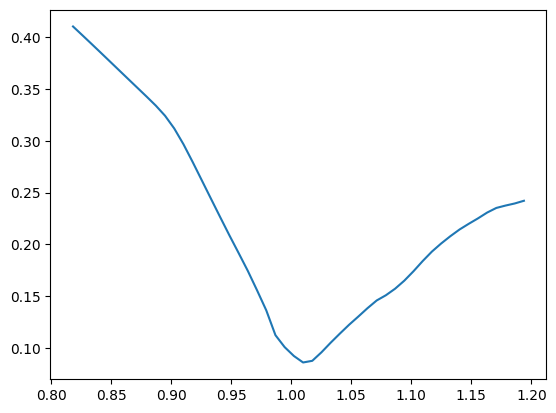

In [ ]:
plt.plot(X_rescaled[0], Z_scaled[0])

In [39]:
# Choose a fixed time to maturity value (you can choose any value from the grid)
fixed_time_to_maturity = 1  # For example, fix time_to_maturity at 0.5


iv_vs_moneyness = Z_scaled[:]

np.int64(0)

In [36]:
X_scaled_grid[0]

array([-3.18012422, -3.0685765 , -2.95702877, -2.84548105, -2.73393332,
       -2.6223856 , -2.51083788, -2.39929015, -2.28774243, -2.1761947 ,
       -2.06464698, -1.95309925, -1.84155153, -1.7300038 , -1.61845608,
       -1.50690835, -1.39536063, -1.2838129 , -1.17226518, -1.06071745,
       -0.94916973, -0.83762201, -0.72607428, -0.61452656, -0.50297883,
       -0.39143111, -0.27988338, -0.16833566, -0.05678793,  0.05475979,
        0.16630752,  0.27785524,  0.38940297,  0.50095069,  0.61249842,
        0.72404614,  0.83559386,  0.94714159,  1.05868931,  1.17023704,
        1.28178476,  1.39333249,  1.50488021,  1.61642794,  1.72797566,
        1.83952339,  1.95107111,  2.06261884,  2.17416656,  2.28571429])